# How do transformers find the minimum of a list?


During the interpretability hackcathon in November 2022, my group and I focussed on trying to understand how a transformer performs the relatively simple task of finding the minimum of a list of integers. We managed to get pretty far with this, but I wasn't entirely satisfied with our final result, so I decided to do some further exploration and tidying up of our results.

In this notebook I will train a super simple transformer to find the minimum of two numbers. I will use Neel Nanda's Transformer Lens library to do this, as well as for the subsequent mechanistic interpretability of the transformer.

I will also lay out some further questions I have that I didn't get round to answering, and talk a little about about the significance of the result.

# Transformer Lens Setup

Note to reader: feel free to ignore this section. The only important points are: I am using Neel Nanda's excellent Transformer Lens library, and this notebook is designed to be run on colab!

Note to Ole: check what stuff here needs to be kept or discarded! Probably loads of bloat.

This setup is copied from Neel's main demo colab notebook for Transformer Lens, which can be found here: https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/Main_Demo.ipynb#scrollTo=V-IJnEFkEBPa

In [1]:
import google.colab
IN_COLAB = True
print("Running as a Colab notebook")
%pip install git+https://github.com/neelnanda-io/TransformerLens.git
%pip install circuitsvis

# PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
# # Install another version of node that makes PySvelte work way faster
# !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
# %pip install git+https://github.com/neelnanda-io/PySvelte.git

Running as a Colab notebook
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-yvc3eihl
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-yvc3eihl
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit 006599b30fd6950b3b07c54eabbdaa7c36939595
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 4.6 MB/s eta 0:00

In [2]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [3]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from torchtyping import TensorType as TT
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [4]:
%matplotlib inline
import time
import pylab as pl
import matplotlib.pyplot as plt
from IPython import display

In [5]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

In [6]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
import os
try:
  mkdir(Path('/content/'))
except:
  pass
root = Path('/content/a')
try:
  os.mkdir(root)
except:
  pass
large_root = Path('/content/b')
try:
  os.mkdir(large_root)
except:
  pass

# Wrapper for training a transformer 

Summary: this is a function which trains a transformer model on some algorithmic task. In principle this should be able to be used to train transformers on general algotihmic tasks, for any given set of data, function, and desired configuration for a transformer. In practise, I have only used it for a few simple tasks like this!

The hyperparameters of the optimizer / the scheduler are hard-coded, and copied from those used by Neel in his grokking paper. I'd be lying if I said I'd tried to properly understand all of them, but I think the most important one is setting weight decay all the way to 1.0 (heavy regularisation gives a big incentive to the network to learn the simplest model it can, which helps prevent overfitting).

Asides: I tried to make this a class, but got very bad memory leaks. It would be nice to modularise this more nicely, but it works for my purposes!

I also tried to make it a bit nicer using decorators to wrap the train model function, but this ended up being more hastle than it was worth.

In [9]:
# New code for Neel-style task

%matplotlib inline
import time
import pylab as pl
import matplotlib.pyplot as plt
from IPython import display


def train_model(data, fn, cfg, device='cuda', split=0.7,seed=42,num_epochs=2000):
  def cross_entropy_high_precision(logits, labels):
      logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
      prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
      loss = -torch.mean(prediction_logprobs)
      return loss

  def full_loss(model, data, labels):
      # Take the final position only
      logits = model(data)[:, -1]
      return cross_entropy_high_precision(logits, labels)

  # Do the initial setup
  # Create HookedTransformer Model
  model = HookedTransformer(cfg).to(device)
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.98), weight_decay=1.0)
  scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))
  # Generate train and test split
  random.seed(seed)
  random.shuffle(data)
  div = int(split*len(data))
  train, test = torch.tensor(data[:div]).to(device), torch.tensor(data[div:]).to(device)
  train_labels = torch.tensor([fn(x) for x in train]).to(device)
  test_labels = torch.tensor([fn(x) for x  in test]).to(device)

  #Saving the runs
  run_name = f"grok_{int(time.time())}"
  save_every = 1000
  try:
    os.mkdir(root/run_name)
  except:
    pass

  print("device =", device)

  def cross_entropy_high_precision(logits, labels):
      logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
      prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
      loss = -torch.mean(prediction_logprobs)
      return loss


  def full_loss(model, data, labels):
      # Take the final position only
      logits = model(data)[:, -1]
      return cross_entropy_high_precision(logits, labels)

  train_losses = []
  test_losses = []
  for epoch in tqdm.tqdm(range(num_epochs + 1)):
      train_loss = full_loss(model, train, train_labels)
      test_loss = full_loss(model, test, test_labels)
      train_losses.append(train_loss.item())
      test_losses.append(test_loss.item())

      train_loss.backward()
      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()
      torch.cuda.empty_cache()
        
      if epoch%save_every == 0:
          save_dict = {
                  'model': model.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'scheduler': scheduler.state_dict(),
                  'train_loss': train_loss,
                  'test_loss': test_loss,
                  'epoch': epoch,
          }
          torch.save(save_dict, root/run_name/f"{epoch}.pth")
          print(f"Saved model to {root/run_name/f'{epoch}.pth'}")
      
      if epoch % 100 == 0:
        plt.semilogy(list([l for l in train_losses]), color="blue")
        plt.semilogy(list([l for l in test_losses]), color="red")
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(0.01)

      if epoch % 100 == 0:
        print(f"Epoch: {epoch}. Loss: {train_loss}")
  
  return model

# Some Interpretability Tools

When trying to understand the low level behaviour of a model, it's useful to have some tools off the shelf to help with this. 

The underlying information for our models is made accessible via the Transformer Lens library. The code for the OV copying score functions also came from Neel's Transformer Lens Demo, and the idea behind these was explained in Anthropic's "A mathematical Framework for Transformer Circuits".

In [10]:
import circuitsvis as cv

def plot_logits(model, input):
  input = torch.tensor(input)
  logits, cache = model.run_with_cache(input, remove_batch_dim = True)
  fig, ax = plt.subplots(figsize=(40,4))
  ax.plot(logits[0][-1].cpu().detach().numpy())
  plt.show()

def generate_attn_pattern(model, input):
  input = torch.tensor(input)
  logits, cache = model.run_with_cache(input, remove_batch_dim = True)
  attn_pattern = cache["pattern", 0, "attn"]
  return cv.attention.attention_patterns(tokens = [str(t) for t in list(input.detach().cpu().numpy())], attention = attn_pattern)

def OV_copying_score(model):
  OV_circuit_all_heads = model.OV
  OV_circuit_all_heads_eigenvalues = OV_circuit_all_heads.eigenvalues 
  OV_copying_score2 = OV_circuit_all_heads_eigenvalues.sum(dim=-1).real / OV_circuit_all_heads_eigenvalues.abs().sum(dim=-1)
  return OV_copying_score2

def OV_full_copying_score(model):
  OV_circuit_all_heads = model.OV
  full_OV_circuit = model.embed.W_E @ OV_circuit_all_heads @ model.unembed.W_U
  full_OV_circuit_eigenvalues = full_OV_circuit.eigenvalues
  full_OV_copying_score = full_OV_circuit_eigenvalues.sum(dim=-1).real / full_OV_circuit_eigenvalues.abs().sum(dim=-1)
  return full_OV_copying_score

# Seeing what happens if we simply embed and then unembed
def embed_unembed_copying_score(model):
  nothing = FactoredMatrix(model.embed.W_E, model.unembed.W_U)
  nothing_eigenvalues = nothing.eigenvalues
  nothing_score = nothing_eigenvalues.sum(dim=-1).real / nothing_eigenvalues.abs().sum(dim=-1)
  return nothing_score


# Training our Model


Here is the configuration of the transformer we will train to find the minimum of two numbers, which range from 0 - 99.

Some important aspects to note about the configuration. Note that generally, I have made the configuration as simple as possible, in order to aid in interpreting it.
1. The dimension space of the model is actually bigger than the range of numbers that can be input to the transformer. (d_model > d_vocab)
2. I am using a single attention layer, and a single attention head within this layer. (n_layers and n_heads)
3. I am not applying Layer normalisation.
4. I am not using the MLP layer.

Note that by default, some form of positional embedding is occurring (I'm unsure how to turn this off, try to figure out to do this if possible!)

In [11]:
p = 100
d_vocab = p+1
n_ctx = 2

tiny_cfg2 = HookedTransformerConfig(
    d_model=128,
    d_head=128//1,
    n_heads=1,
    attn_only=True,
    n_layers=1,
    n_ctx=n_ctx,
    act_fn="relu", #solu_ln
    d_vocab=d_vocab,
    normalization_type=None, #"LN",
    seed=23,  # Check this seed is actually used somewhere lmao
)


Every pair of numbers from 0-99 is being used for either training or validation. Importantly, there is no cross-over between the training and validation datasets.
(I think that) the entire training set is used in a single epoch of training, and the entire validation set is used each time the model is validated. 

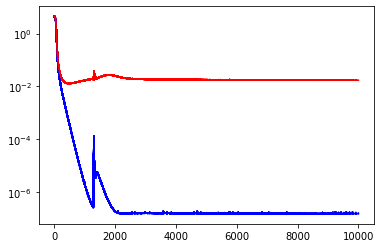

Epoch: 10000. Loss: 1.4813286745722305e-07


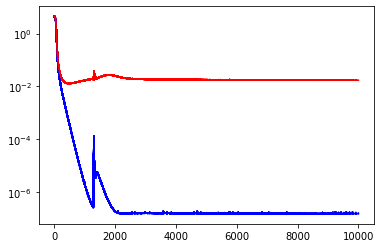

In [12]:
data = [(i, j) for i in range(p) for j in range(p)]

fn = lambda x:min(x)

small_model = train_model(data, fn, tiny_cfg2, num_epochs=10000)

Let's get the accuracy of the final model:

In [51]:
correct = 0
false = 0
for point in data:
  if int(torch.argmax(small_model(torch.tensor(point))[0][-1])) == min(point):
    correct += 1
  else:
    break
    false += 1

In [53]:
print(correct / (correct + false)) 

1.0


It's pretty good!

# Recap of how GPT-2 style models work


In order to understand the following analysis, I think that it is pretty important to understand how transformers work in general, and I think it is relatively important to understand how GPT-2 style transformers work specifically. I'm not going to go into great detail here, but I will recap some basic points. For a further and more detailed explanation of this, I'd suggest going through Anthropic's "A Mathematical Framework for Transformer Circuits", as well as Neel's accompanying walkthrough video (I found the latter very useful, to the extent that friends often tease me for bringing it up in conversations).

Ole note: do I need to include this?

#Super Basic Interpretability 

In [46]:
input = np.random.choice(100,2)
input

array([31, 76])

Let's take a look at its attention pattern. This corresponds to the model asking "to which token in the input should the most attention be paid".

In [48]:
generate_attn_pattern(small_model, input)

Note that

 Let's have a look at its logits, for this random input.
(Maybe include this elsewhere?? Maybe not, also) (As a reminder, logits are the raw output of the transformer, before we apply softmax to the outputs to get a probabilistic looking answer).

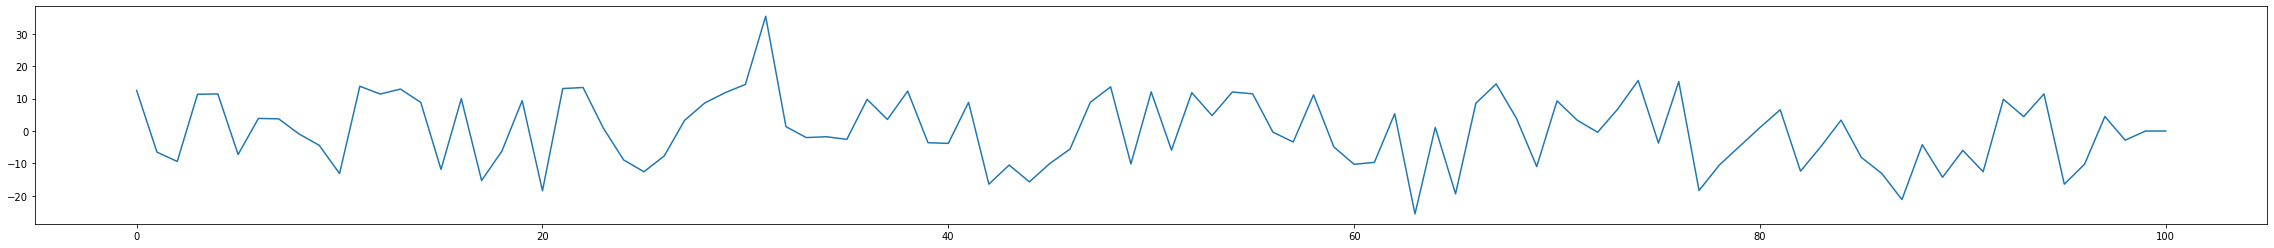

In [47]:
plot_logits(small_model, input)

The only distinguishable pattern here is that there is a clear peak at the minimum (31), with what looks essentially like noise for all other values.

This is essentially where we got to at the end of the Hackathon (most of our time was spent trying to train a transformer in the first place!). The story we could convincingly tell at the end of this was "transformers pay the most attention to the token corresponding to the smallest input". 

Although I still agree this is true, I think we can tell a more comprehensive story than this!

# How I think it is working

Here is how I think the transformer is working. I'll try to highlight my key uncertainties, and why my justification for each claim.

Overall, I think the algorithm being carried out by the transformer is:
1. Pay attention to an input number, corresponding to how small that input is. The smaller the number, the more attention we pay to that input.
2. Then, once we are paying attention to a number, we are going to simply copy over the vector corresponding to that number, and add it to the residual stream. (uncertain: if the size of the vector we copy over is really big, then it will dwarf the original vector in the residual stream. This essentially means it is just replacing the original vector with the new one!)

## Claim 1: attention scores are negatively proportional to the size of the number.

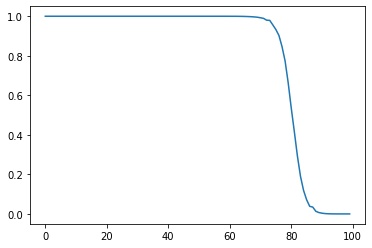

In [14]:
# Hold the second token constant, look at the attention pattern
attn_to_i = []
for i in range(100):
  input = torch.tensor([i, 80])
  logits, cache = small_model.run_with_cache(input, remove_batch_dim = True)
  attn_pattern = cache["pattern", 0, "attn"]
  attn_to_i.append(float(attn_pattern[0][-1][0]))

plt.plot(range(100), attn_to_i)


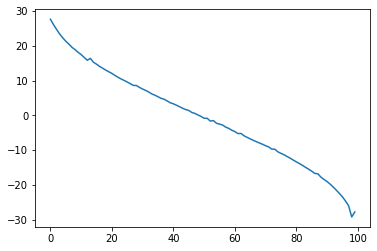

In [15]:
# Hold the second token constant, look at the attention pattern
attn_to_69 = []
attn_to_42 = []
for i in range(100):
  input69 = torch.tensor([i, 69])
  logits, cache = small_model.run_with_cache(input69, remove_batch_dim = True)
  attn_pattern69 = cache["attn_scores", 0, "attn"]
  attn_to_69.append(float(attn_pattern69[0][-1][0]))
  input42 = torch.tensor([i, 42])
  logits, cache = small_model.run_with_cache(input42, remove_batch_dim = True)
  attn_pattern42 = cache["attn_scores", 0, "attn"]
  attn_to_42.append(float(attn_pattern42[0][-1][0]))

plt.plot(range(100), attn_to_69)

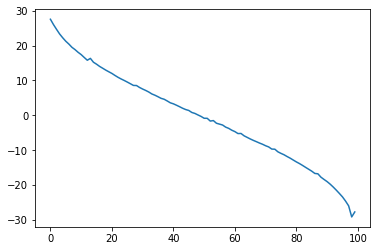

In [16]:
plt.plot(range(100), attn_to_42)

In [17]:
attn_diff = [a - b for (a,b) in zip(attn_to_69, attn_to_42)]

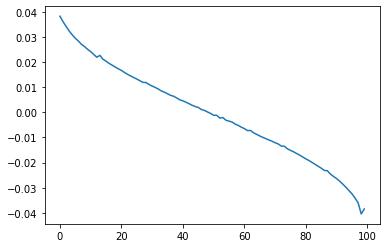

In [18]:
plt.plot(range(100), attn_diff)

In [19]:
# That's super weird!! Let's do it again!!

attn_to_89 = []
attn_to_21 = []
for i in range(100):
  input89 = torch.tensor([i, 89])
  logits, cache = small_model.run_with_cache(input89, remove_batch_dim = True)
  attn_pattern89 = cache["attn_scores", 0, "attn"]
  attn_to_89.append(float(attn_pattern89[0][-1][0]))
  input21 = torch.tensor([i, 21])
  logits, cache = small_model.run_with_cache(input21, remove_batch_dim = True)
  attn_pattern21 = cache["attn_scores", 0, "attn"]
  attn_to_21.append(float(attn_pattern21[0][-1][0]))

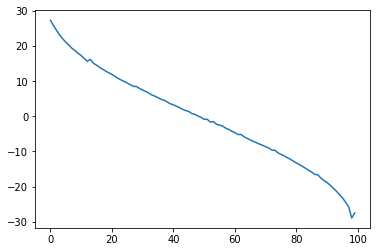

In [20]:
plt.plot(range(100), attn_to_89)

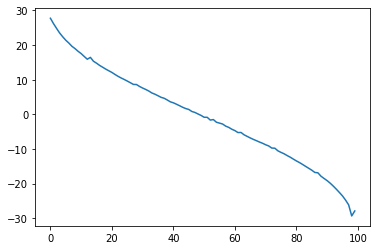

In [21]:
plt.plot(range(100), attn_to_21)

In [22]:
plt.plot(range(100), [a - b for (a,b) in zip(attn_to_69, attn_to_)])

NameError: ignored

In [ ]:
attn_to_31 = []
for i in range(100):
  input31 = torch.tensor([i, 69])
  logits, cache = small_model.run_with_cache(input31, remove_batch_dim = True)
  attn_pattern31 = cache["attn_scores", 0, "attn"]
  attn_to_31.append(float(attn_pattern31[0][-1][0]))

In [ ]:
plt.plot(range(100), [a - b for (a,b) in zip(attn_to_69, attn_to_31)])

In [ ]:
attn_to_69 == attn_to_31

In [ ]:
def make_attn_to_n(n):
  attn_to_n = []
  for i in range(100):
    inputn = torch.tensor([i, n])
    logits, cache = small_model.run_with_cache(inputn, remove_batch_dim = True)
    attn_pattern = cache["attn_scores", 0, "attn"]
    attn_to_n.append(float(attn_pattern[0][-1][0]))
  return attn_to_n

In [ ]:
attn_to_80 = make_attn_to_n(80)
attn_to_20 = make_attn_to_n(20)

In [ ]:
plt.plot(range(100), [a - b for (a,b) in zip(attn_to_80, attn_to_20)])

Weird stuff!

Getting a little look at the logits:

## Claim 2: the model is just copying tokens it pays attention to.

Evidence:
A lot of my evidence is based on the summary statistics developed in the "A Mathematical Framework for Transformers" paper from Anthropic to measure copying. You can see further discussion of them there.

These summary statistics involve ... (complete)

However, let's assume that OV  are in fact good measures of "copying behaviour".

Here are the copying scores both for only the OV circuit, and for the OV circuit with both the embed and unembed layers taken into account.

In [56]:
print(OV_copying_score(small_model))
print(OV_full_copying_score(small_model))

tensor([[0.9826]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.9988]], device='cuda:0', grad_fn=<DivBackward0>)


Since 1 is the maximum value these can reach (varying from -1 to 1), by this measure the OV circuit here can be well described as copying!

Could also include a plot of copying score over time?

In [49]:
#Aside: trying to find eigenvalues to work out how much stretching is occurring!
OV_circuit_all_heads = small_model.OV
OV_circuit_all_heads_eigenvalues = OV_circuit_all_heads.eigenvalues

In [50]:
OV_circuit_all_heads_eigenvalues

tensor([[[ 7.5948e+00+0.0000e+00j,  1.1278e+01+3.7072e+00j,
           1.1278e+01-3.7072e+00j,  1.2924e+01+0.0000e+00j,
           1.2808e+01+1.7348e+00j,  1.2808e+01-1.7348e+00j,
           1.1785e+01+2.3683e+00j,  1.1785e+01-2.3683e+00j,
           1.2188e+01+1.6716e+00j,  1.2188e+01-1.6716e+00j,
           1.0789e+01+0.0000e+00j,  5.3912e-03+1.0783e-03j,
           5.3912e-03-1.0783e-03j,  5.6252e-03+0.0000e+00j,
           5.2918e-03+0.0000e+00j,  4.9500e-03+1.6487e-03j,
           4.9500e-03-1.6487e-03j,  4.4032e-03+1.8752e-03j,
           4.4032e-03-1.8752e-03j,  1.4944e-03+3.8838e-03j,
           1.4944e-03-3.8838e-03j,  3.6131e-03+2.4940e-03j,
           3.6131e-03-2.4940e-03j, -4.2624e-04+3.3613e-03j,
          -4.2624e-04-3.3613e-03j,  1.6848e-03+3.1929e-03j,
           1.6848e-03-3.1929e-03j,  2.7671e-03+2.4358e-03j,
           2.7671e-03-2.4358e-03j,  3.7487e-03+1.5481e-04j,
           3.7487e-03-1.5481e-04j, -1.7868e-03+2.3504e-03j,
          -1.7868e-03-2.3504e-03j,  3.15

## Claim 3: The attention layer is "overpoowering" the residual stream.

A further hypothesis I have about this transformer, is that these networks are not simply copying, but are copying an enlarged version of the token. It makes sense to do this because the output of the OV circuit is being added to the residual stream which contains the embedding of the second token. To minimise the extent to which the embedding of the second token influences the output logits, it seems like a useful strategy to copy over a vector which is as large as possible!

Now, if we were using some form of normalisation such as layer norm, this "overpowering" would not be possible, since it would limit the size of the vector we add back to the residual stream. However, this model doesn't use Layer Norm!
(I think this is how layer norm works)

To try to test this, I'm going to go for the simplest measurement I can think of: just compare the l2 norm of the residual stream before we go through the attention layer, with the l2 norm of the activation of the attention layer (which will be added back to the residual stream).

In [57]:
input

tensor([50, 20])

In [58]:
logits, cache = small_model.run_with_cache(input, remove_batch_dim=True)

Ole note: check whether I should be looking at the output of the embed or the positional embed for this!

In [77]:
torch.norm(cache["resid_pre", 0][-1])

tensor(3.5786, device='cuda:0')

In [78]:
torch.norm(cache["attn_out", 0][-1])

tensor(24.6327, device='cuda:0')

In [79]:
torch.norm(cache["resid_post", 0][-1])

tensor(26.0758, device='cuda:0')

Here is a little sanity check to ensure that we are actually comparing the correct activations!

In [80]:
cache["resid_pre", 0][-1] + cache["attn_out", 0][-1] == cache["resid_post", 0][-1]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True], device='cuda:0')

Now, I'll calculate the average ratio of the output of the attention layer divided by the residual stream before the attention layer, across 100 random inputs.

In [90]:
resid_pre = []
attn_out = []
for i in range(100):
  input = torch.tensor(np.random.choice(100,2))
  logits, cache = small_model.run_with_cache(input, remove_batch_dim=True)
  resid_pre.append(torch.norm(cache["resid_pre", 0][-1]))
  attn_out.append(torch.norm(cache["attn_out", 0][-1]))

ratios = [post / pre for (post, pre) in zip(attn_out, resid_pre)]
sum(ratios)/len(ratios)

tensor(7.2280, device='cuda:0')

The output of the attention layer is on average 7x greater than the output of residual stream! Despite the crudeness of this statistic, it feels like relevant information nonetheless. 

My guess as to why the output of the attention layer isn't even bigger than this is because of the regularisation applied during training. This also makes the above results more significant: the model is having to pay a high penalty to have the high weights necessary to produce large activations in the output, so the fact it is doing so anyway suggests the size of the activations serves an important purpose.

Why isn't the model removing the residual stream, and replacing it entirely with the output of the attention layer? (Expand) 1-layer transformers cannot do this! (Think about if this is true for transformers with more layers, MLP, etc.)


In fact, I suspect that this might be generalisable to other transformers where a single attention layer is essentially able to compute the correct answer: a strategy of "shout so loud the opinions of others cannot be heard" might well be the learned behaviour here! :)) (expand on this in the takeaways section)

#Caveats and Issues with my Analysis

1. I wasn't able to train a model without positional encoding, because I wasn't sure how to do that using the Transformer Lens library! I suspect this might have  removed some of the noise from the output logits, but I'm unsure about this.
2.   